In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

In [2]:
land_df = pd.read_csv("daily_corona_data/aggregate_bundesland.csv", index_col=0)
land_df.Meldedatum = land_df.Meldedatum.transform(lambda x: datetime.datetime.strptime(re.sub("T.*", "", x), "%Y-%m-%d"))
land_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 278
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meldedatum             293 non-null    datetime64[ns]
 1   Bundesland             293 non-null    object        
 2   AnzahlFall             293 non-null    int64         
 3   AnzahlTodesfall        293 non-null    int64         
 4   TotalAnzahlBundesland  293 non-null    int64         
 5   TotalDeathBundesland   293 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 16.0+ KB


In [3]:
datetime.datetime.strptime("2020-01-03", "%Y-%m-%d")

datetime.datetime(2020, 1, 3, 0, 0)

In [4]:
type(land_df.iloc[0, 0])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
lander = land_df.Bundesland.unique()
lander = [land for land in lander if land != "-nicht erhoben-"]

In [6]:
tot_pops = {'Bayern': 13076721,
            'Schleswig-Holstein': 2896712,
            'Hamburg': 1841179,
            'Bremen': 82986,
            'Nordrhein-Westfalen': 17932651,
            'Hessen': 6265809,
            'Rheinland-Pfalz': 4084844,
            'Baden-Württemberg': 11069533,
            'Saarland': 990509,
            'Berlin': 3644826,
            'Mecklenburg-Vorpommern': 1609675,
            'Sachsen': 4077937,
            'Sachsen-Anhalt': 2208321,
            'Thüringen': 2143145,
           }

In [7]:
R0s = {"Bayern": 2.5, "Baden-Württemberg": 5, "Nordrhein-Westfalen": 4.8, "Saarland": 5.5}

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


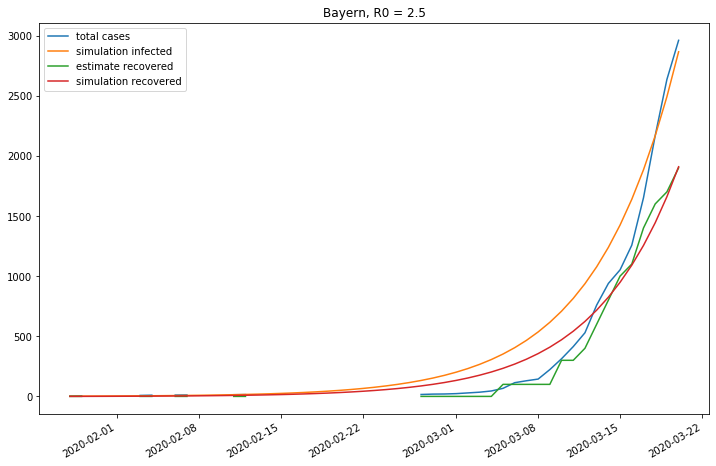

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


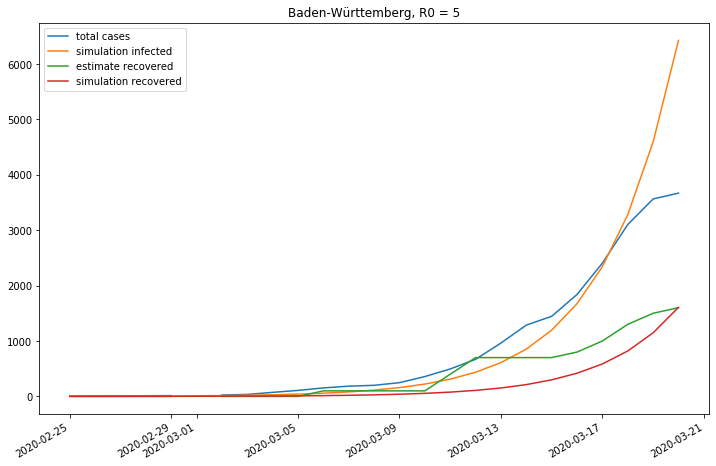

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


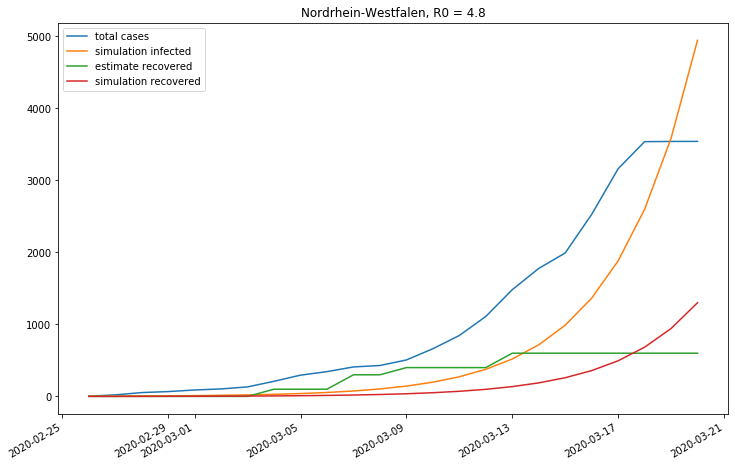

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


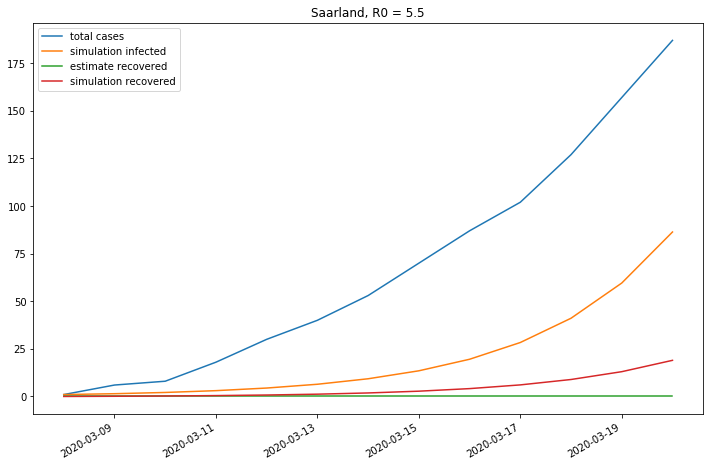

In [8]:
for land in ["Bayern", "Baden-Württemberg", "Nordrhein-Westfalen", "Saarland"]:
    temp_df = land_df[land_df.Bundesland == land]
    day_0 = temp_df.iloc[0].Meldedatum
    n_days =(temp_df.iloc[-1].Meldedatum - temp_df.iloc[0].Meldedatum).days + 1
    temp_df = temp_df.set_index("Meldedatum")
    tot_pop = tot_pops[land]

    i_0 = temp_df.loc[day_0, "TotalAnzahlBundesland"] / tot_pop
    r_0 = temp_df.loc[day_0, "TotalDeathBundesland"] * 10 * 10 / tot_pop
    s_0 = 1 - i_0 - r_0

    evol = [{"i": i_0, "r": r_0, "s": s_0}]

    R0 = R0s[land]
    g = 1 / 10
    b = R0 * g

    for day in range(1, n_days):
        s = evol[-1]["s"]
        r = evol[-1]["r"]
        i = evol[-1]["i"]
        new_s = s - b * i * s
        new_r = r + g * i
        new_i = i + b * i * s - g * i
        evol.append({"s": new_s, "r": new_r, "i": new_i})

    temp_df = temp_df.join(pd.DataFrame(evol, index=[day_0 + datetime.timedelta(days=j) for j in range(n_days)]) * tot_pop, how="outer")
    # Assume that 10% of the hospitalized die, and 10% of the sick are hospitalized
    temp_df["Recovered"] = temp_df.TotalDeathBundesland * 10 * 10

    fig = plt.figure(figsize=(12, 8))
    plt.title(f"{land}, R0 = {R0}")
    plt.plot(temp_df.index, 'TotalAnzahlBundesland', data=temp_df, label="total cases")
    plt.plot(temp_df.index, 'i', data=temp_df, label="simulation infected")
    plt.plot(temp_df.index, 'Recovered', data=temp_df, label="estimate recovered")
    plt.plot(temp_df.index, 'r', data=temp_df, label="simulation recovered")
    plt.legend()
    fig.autofmt_xdate()
    plt.show()

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


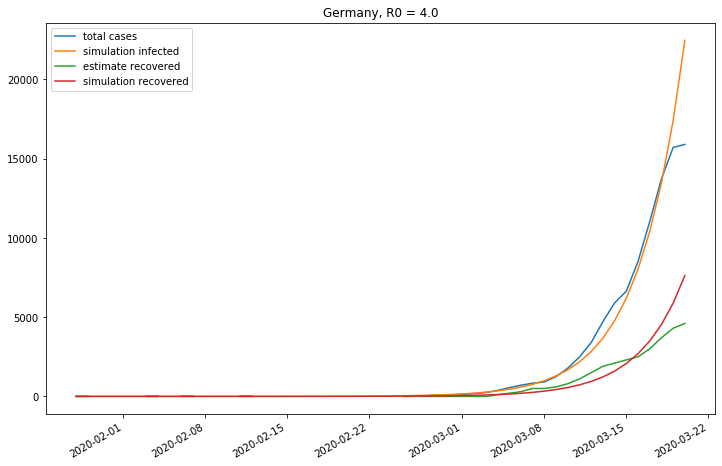

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


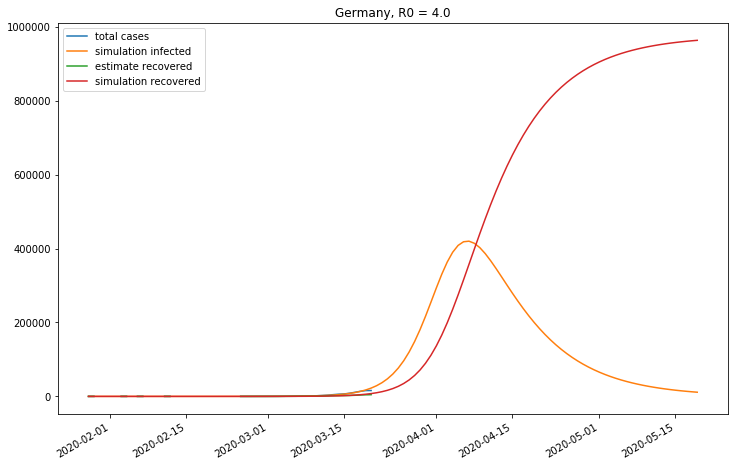

In [19]:
tot = np.sum([val for key, val in tot_pops.items()])
temp_df = land_df.groupby("Meldedatum", as_index=False).sum()

day_0 = temp_df.iloc[0].Meldedatum
n_days =(temp_df.iloc[-1].Meldedatum - temp_df.iloc[0].Meldedatum).days + 1
temp_df = temp_df.set_index("Meldedatum")

i_0 = temp_df.loc[day_0, "TotalAnzahlBundesland"] / tot
r_0 = temp_df.loc[day_0, "TotalDeathBundesland"] * 20 * 10 / tot
s_0 = 1 - i_0 - r_0

evol = [{"i": i_0, "r": r_0, "s": s_0}]

R0 = 4.0
g = 1 / 10
b = R0 * g

extra_days = 60

for day in range(1, n_days + extra_days):
    s = evol[-1]["s"]
    r = evol[-1]["r"]
    i = evol[-1]["i"]
    new_s = s - b * i * s
    new_r = r + g * i
    new_i = i + b * i * s - g * i
    evol.append({"s": new_s, "r": new_r, "i": new_i})

full_df = temp_df.join(pd.DataFrame(evol[:-extra_days], index=[day_0 + datetime.timedelta(days=j) for j in range(n_days)]) * tot_pop, how="outer")
# Assume that 10% of the hospitalized die, and 15% of the sick are hospitalized
full_df["Recovered"] = full_df.TotalDeathBundesland * 10 * 10

fig = plt.figure(figsize=(12, 8))
plt.title(f"Germany, R0 = {R0}")
plt.plot(full_df.index, 'TotalAnzahlBundesland', data=full_df, label="total cases")
plt.plot(full_df.index, 'i', data=full_df, label="simulation infected")
plt.plot(full_df.index, 'Recovered', data=full_df, label="estimate recovered")
plt.plot(full_df.index, "r", data=full_df, label="simulation recovered")
plt.legend()
fig.autofmt_xdate()
plt.show()

full_df = temp_df.join(pd.DataFrame(evol, index=[day_0 + datetime.timedelta(days=j) for j in range(n_days + extra_days)]) * tot_pop, how="outer")
# Assume that 10% of the hospitalized die, and 15% of the sick are hospitalized
full_df["Recovered"] = full_df.TotalDeathBundesland * 10 * 10

fig = plt.figure(figsize=(12, 8))
plt.title(f"Germany, R0 = {R0}")
plt.plot(full_df.index, 'TotalAnzahlBundesland', data=full_df, label="total cases")
plt.plot(full_df.index, 'i', data=full_df, label="simulation infected")
plt.plot(full_df.index, 'Recovered', data=full_df, label="estimate recovered")
plt.plot(full_df.index, 'r', data=full_df, label="simulation recovered")
plt.legend()
fig.autofmt_xdate()
plt.show()